# Mock Gain Calibration

In [47]:
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt

In [49]:
NSAMPLES = 1024
NBLOCKS = 5000

# Making up some temperatures; these *don't* correspond to reality!
T = {
    'cold': 10, # K, the temperature of the cold sky
    'load': 300, # K, the temperature of a blackbody calibration source
    'HI': 20, # K, the brightness temperature of the 21 cm signal from HI
    'sys': 150, # K, the system temperature from Johnson Noise in amplifiers
}

fq_s = 62.5 # MHz, the ADC sample frequency

lo = 1420.0 # MHz, the sum of the LO frequencies mixing RF to the IF we sample
fq0 = 1420.405 # MHz, the rest frequency of the HI line
dfq = 0.27 # MHz, the offset of the HI line from the rest frequency
dstd = 0.1 # MHz, width of the HI line profile

G_true = 2.718e2 # cnts / sqrt(K), an arbitrary number relating temperature to ADC voltage counts
G_real = 0.8 # fractional power of sampled real (A-port) signal
G_imag = 1.2 # fractional power of sampled imag (B-port) signal

BP_SIZE = 32
bandpass = np.ones(BP_SIZE)
bandpass[:BP_SIZE//4] = 0
bandpass[-BP_SIZE//4:] = 0
bandpass = np.fft.fftshift(bandpass)
bandpass.shape = (1,1,-1)

In [12]:
def gaussian_noise(shape, mean=0.0, std=1.0):
    '''Return gaussian-distributed stochastic noise.'''
    real = np.random.normal(size=shape, loc=mean, scale=std)
    imag = np.random.normal(size=shape, loc=mean, scale=std)
    noise = (real + 1j * imag) / np.sqrt(2)
    return noise

test_noise = gaussian_noise((NBLOCKS, NSAMPLES))
np.testing.assert_almost_equal(np.mean(np.abs(test_noise)**2), 1, 2) # Errors if we don't get the expected answer

In [32]:
# Create mock 'true' signals
V = {key: gaussian_noise((NBLOCKS, NSAMPLES), std=np.sqrt(temp)) for key,temp in T.items()}
times = np.arange(NSAMPLES) / fq_s # us, time samples
freqs = np.fft.fftfreq(times.size, np.median(np.diff(times)))
times.shape = (1,-1)
freqs.shape = (1, -1)
HI = V['HI'] * np.exp(-2j*np.pi * (fq0 + dfq - lo) * times) # modulate down to 0 MHz
_HI = np.fft.fft(HI)
_HI *= np.sqrt(np.exp(-freqs**2 / (2 * dstd**2))) # sqrt to apply to voltage, not power
HI = np.fft.ifft(_HI)
V['HI'] = HI * np.exp(2j*np.pi * (fq0 + dfq - lo) * times) # modulate back up to dfq

Text(0, 0.5, 'Temperature [K]')

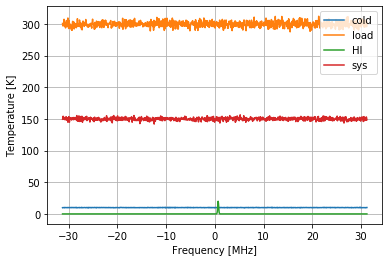

In [33]:
# Visualize mock 'true' signals
plt.figure()
for key,val in V.items():
    _d = np.fft.fft(val)
    pwr = np.average(np.abs(_d)**2, axis=0) / NSAMPLES
    plt.plot(np.fft.fftshift(freqs[0]), np.fft.fftshift(pwr), label=key)
plt.legend()
plt.grid()
plt.xlabel('Frequency [MHz]')
plt.ylabel('Temperature [K]')

In [61]:
# Corrupt signal
V_meas = {
    'sky': V['sys'] + V['cold'] + V['HI'], # on-sky measurement
    'load': V['sys'] + V['load'], # load measurement, assuming no sky
    'inj': V['sys'] + V['cold'] + V['HI'] + V['load'], # load measurement, assuming add to sky
}

for key,val in V_meas.items():
    val.shape = (val.shape[0], -1, bandpass.size)
    _val = np.fft.fft(val)
    _val *= bandpass
    val = np.fft.ifft(_val)
    val.shape = (val.shape[0], -1)
    val *= G_true
    val.real *= G_real
    val.imag *= G_imag
    V_meas[key] = val

<IPython.core.display.Javascript object>


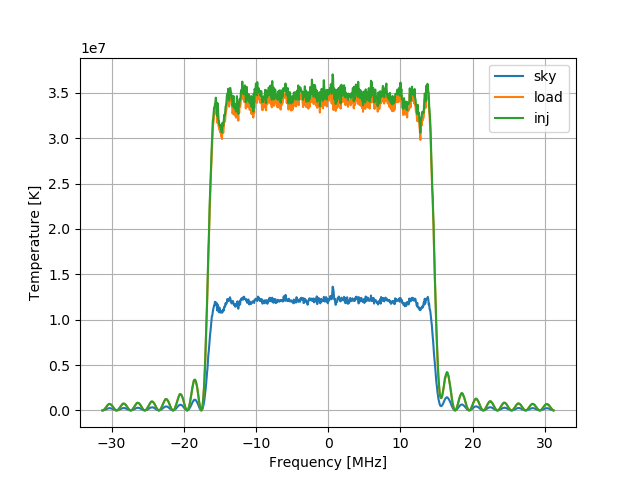

Text(0, 0.5, 'Temperature [K]')

In [62]:
# Visualize mock 'true' signals
plt.figure()
for key,val in V_meas.items():
    _d = np.fft.fft(val)
    pwr = np.average(np.abs(_d)**2, axis=0) / NSAMPLES
    plt.plot(np.fft.fftshift(freqs[0]), np.fft.fftshift(pwr), label=key)
plt.legend()
plt.grid()
plt.xlabel('Frequency [MHz]')
plt.ylabel('Temperature [K]')

<IPython.core.display.Javascript object>


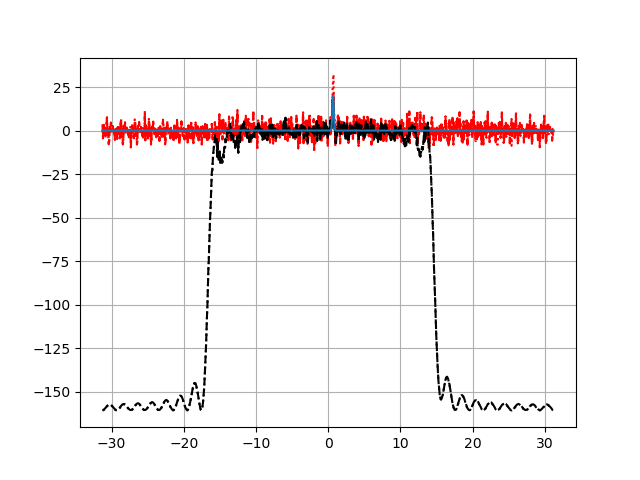

In [73]:
# *Incorrect* Calibration
P = {key:np.mean(np.abs(np.fft.fft(val))**2, axis=0) for key,val in V_meas.items()}
G_wrong1 = (T['load'] - T['cold']) / (P['load'] - P['sky'])
G_wrong2 = (T['load']) / (P['inj'] - P['sky'])
Tsys_wrong1 = np.mean(G_wrong1 * P['sky'])
Tsys_wrong2 = np.mean(G_wrong2 * P['sky'])
fitband = np.abs(freqs[0]) < 8
G_better1 = (T['load'] - T['cold']) / np.mean(P['load'][fitband] - P['sky'][fitband])
G_better2 = (T['load']) / np.mean(P['inj'][fitband] - P['sky'][fitband])
Tsys_better1 = np.mean(G_better1 * P['sky'][fitband])
Tsys_better2 = np.mean(G_better2 * P['sky'][fitband])
plt.figure()
plt.plot(np.fft.fftshift(freqs[0]), np.fft.fftshift(G_wrong1 * P['sky'] - Tsys_wrong1), 'r:')
plt.plot(np.fft.fftshift(freqs[0]), np.fft.fftshift(G_wrong2 * P['sky'] - Tsys_wrong2), 'r--')
plt.plot(np.fft.fftshift(freqs[0]), np.fft.fftshift(G_better1 * P['sky'] - Tsys_better1), 'k:')
plt.plot(np.fft.fftshift(freqs[0]), np.fft.fftshift(G_better2 * P['sky'] - Tsys_better2), 'k--')
pwr = np.average(np.abs(np.fft.fft(V['HI']))**2, axis=0) / NSAMPLES
plt.plot(np.fft.fftshift(freqs[0]), np.fft.fftshift(pwr))
plt.grid()